# Exploratory Data Analysis: Fase 2

## Indice
1. [Importaciones y contexto](#importaciones-y-contexto)
2. [Análisis Univariante](#analisis-univariante)
    - [Variables numéricas](#variables-numericas)
    - [Variables categóricas](#variables-categoricas)
3. [Análisis Bivariante](#analisis-bivariante)
    - [Variables numéricas](#variables-numericas-vs-target)
    - [Variables Categóricas](#variables-categoricas-vs-target)

4. [Guardado de features](#guardado-final-de-features)
    - [Definición de features finales](#definición)


# Importaciones y contexto

In [30]:
# =========================
# Importación de librerías
# =========================

# --- Sistema y rutas ---
import os
import sys
utils_path = os.path.abspath("../utils")  # Añadir ruta de módulos auxiliares
sys.path.append(utils_path)

# --- Manipulación de datos ---
import pandas as pd
import numpy as np
import math


# --- Visualización ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Soporte y análisis ---
import warnings

# --- Módulos propios ---
import eda as eda  # Funciones personalizadas del proyecto

# --- Configuración global ---
warnings.filterwarnings('ignore')  # Ignorar warnings innecesarios


In [31]:
import importlib
importlib.reload(eda)

<module 'eda' from 'c:\\Users\\javie\\Documents\\Portafolio_DS\\ToxiPredict\\src\\utils\\eda.py'>

In [32]:
# Dataset de entrenamiento
df_trainval = pd.read_csv("../../data/interim/trainval.csv")

# Visualización
df_trainval.head()

,test_id,reference_number,test_cas,test_location,test_exposure_type,test_control_type,test_media_type,test_application_freq_unit,test_organism_lifestage,result_id,...,split_random,split_occurrence,split_scaffold-murcko,split_scaffold-murcko-loo-0,split_scaffold-murcko-loo-1,split_scaffold-murcko-llo,split_scaffold-generic,split_scaffold-generic-loo-0,split_scaffold-generic-loo-1,split_scaffold-generic-llo
0,1001265,182,94-09-7,LAB,S,I,FW,X,NR,112643,...,3,2,4,test,trainvalid,trainvalid,4,test,trainvalid,trainvalid
1,1001266,182,94-09-7,LAB,S,I,FW,X,NR,112644,...,3,2,4,test,trainvalid,trainvalid,4,test,trainvalid,trainvalid
2,1001694,225,52918-63-5,LAB,S,I,FW,X,NR,111395,...,3,2,2,trainvalid,trainvalid,trainvalid,2,trainvalid,trainvalid,trainvalid
3,1001695,225,52918-63-5,LAB,S,I,FW,X,NR,111396,...,3,2,2,trainvalid,trainvalid,trainvalid,2,trainvalid,trainvalid,trainvalid
4,1001696,225,52918-63-5,LAB,S,I,FW,X,NR,111397,...,3,2,2,trainvalid,trainvalid,trainvalid,2,trainvalid,trainvalid,trainvalid


In [33]:
# Nombre de la variable objetivo
target = "result_conc1_mean_binary"

# Separación
X_train = df_trainval.drop(columns=target).copy()
y_train = df_trainval[target].copy()

In [34]:
# Lectura de la plantilla de análisis resultante del notebook de trabajo previo (02_Variables_Features)
plantilla_analisis = pd.read_csv("../../data/interim/plantilla_analisis_final.csv", index_col=0)

In [35]:
# asegurar que las top features de RF estén marcadas como 'mantener'

# Cargar top features de Random Forest
top_rf = pd.read_csv("../../data/interim/features_rf.csv").head(20)

# Extraer el nombre original de cada variable (quitar prefijos como 'standardscaler__')
top_rf["nombre_variable"] = top_rf["feature"].apply(lambda x: x.split("__")[-1])

# Forzar que estén marcadas como mantener en la plantilla
plantilla_analisis.loc[
    plantilla_analisis["nombre_variable"].isin(top_rf["nombre_variable"]),
    ["expectativas", "conclusion"]
] = ["alta (RF)", "mantener"]


In [36]:
# 1. Filtrado de variables válidas para EDA

# Selección de las variables marcadas como "mantener"
vars_mantener = plantilla_analisis.query("conclusion == 'mantener'")["nombre_variable"].tolist()

# Nuevo DataFrame solo con esas columnas
X_train_validadas = X_train[vars_mantener].copy()
print(f"Variables seleccionadas para EDA: {len(vars_mantener)}\n")

Variables seleccionadas para EDA: 613



In [37]:
# 2. Separación por tipo de variable

# Separar en numéricas y categóricas 
vars_numericas = X_train_validadas.select_dtypes(include=['float64', 'int64']).columns.tolist()
vars_categoricas = X_train_validadas.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

print(f"Variables numéricas: {len(vars_numericas)}")
print(f"Variables categóricas: {len(vars_categoricas)}")

# Vista previa rápida
X_train_validadas[vars_numericas].describe().T.round(2)


Variables numéricas: 592
Variables categóricas: 21


,count,mean,std,min,25%,50%,75%,max
result_obs_duration_mean,21981.0,67.52,31.03,24.00,24.00,96.00,96.00,96.00
media_ph_mean,13669.0,7.50,0.55,3.00,7.20,7.40,7.80,10.00
media_temperature_mean,16468.0,18.75,5.88,1.60,12.00,20.00,24.60,40.00
tax_ps_ampv,21981.0,0.04,0.03,0.01,0.02,0.04,0.06,0.22
tax_ps_ampkap,21981.0,0.77,0.20,0.34,0.62,0.75,0.94,1.00
...,...,...,...,...,...,...,...,...
chem_mordred_AMW,21981.0,10.24,4.28,4.31,7.36,9.09,11.72,49.95
chem_mordred_WPol,21981.0,21.95,13.18,0.00,13.00,21.00,30.00,104.00
chem_mordred_Zagreb1,21981.0,75.82,37.04,2.00,54.00,72.00,98.00,230.00
chem_mordred_Zagreb2,21981.0,87.65,48.50,1.00,56.00,80.00,112.00,323.00


 Hay 604 variables marcadas como "mantener". Analizarlas todas manualmente sería inviable y contraproducente. La mejor estrategia para priorizar es:

- Priorizar las más relevantes según modelos previos
    - `RandomForestClassifier.feature_importances_`
    - `SelectKBest `

Estrategia:
Crear un ranking combinado y seleccionar el top 20 de cada tipo (numéricas y categóricas).

In [38]:
# Priorización de variables por importancia combinada

# 1. Cargar archivos con rankings
rf = pd.read_csv("../../data/interim/features_rf.csv")
kbest = pd.read_csv("../../data/interim/features_kbest.csv")

# 2. Limpiar nombres de variables transformadas en RF
rf["nombre_variable"] = rf["feature"].apply(lambda x: x.split("__")[-1])

# 3. Calcular rankings individuales
rf["ranking_rf"] = rf["importance"].rank(ascending=False).astype(int)
kbest["ranking_kbest"] = kbest["score_f"].rank(ascending=False).astype(int)

# 4. Unir rankings por nombre original
df_merge = pd.merge(
    rf[["nombre_variable", "ranking_rf"]],
    kbest[["nombre_variable", "ranking_kbest"]],
    on="nombre_variable",
    how="outer"
)

# 5. Definir variables a analizar (Top RF + KBest + prioritarias)
prioritarias = [
    "tax_gs",                   
    "test_exposure_type",
    "test_organism_lifestage",
    "result_endpoint",
    "tax_family",
    "tax_eco_migrate2"
]
top_rf = rf["nombre_variable"].tolist()
top_kbest = kbest["nombre_variable"].tolist()
vars_analizar = list(set(top_rf + top_kbest + prioritarias))

# 6. Filtrar y ordenar por ranking combinado
df_merge["ranking_combinado"] = df_merge[["ranking_rf", "ranking_kbest"]].min(axis=1)
df_ordenadas = df_merge[df_merge["nombre_variable"].isin(vars_analizar)].copy()
df_ordenadas = df_ordenadas.sort_values("ranking_combinado").reset_index(drop=True)

# 7. Lista final ordenada de variables
vars_analizar_ordenadas = df_ordenadas["nombre_variable"].tolist()

# 8. Asegurar que las prioritarias estén incluidas
for var in prioritarias:
    if var not in vars_analizar_ordenadas:
        vars_analizar_ordenadas.append(var)

# 9. Visualizar resumen
print(f"Variables ordenadas para análisis (incluyendo prioritarias): {len(vars_analizar_ordenadas)}")


Variables ordenadas para análisis (incluyendo prioritarias): 46


### Priorización de variables por importancia combinada

Para facilitar la interpretación y optimizar el tiempo de análisis, las variables seleccionadas por Random Forest (`importance`) y SelectKBest (`score_f`) se han ordenado de forma descendente según su relevancia respecto al target.

Se ha calculado un ranking combinado, conservando también variables marcadas como prioritarias por conocimiento experto (como `tax_gs`). Esto permite centrar el análisis univariante y bivariante en las variables más prometedoras y representativas del dataset.

### Justificación de inclusión de variables categóricas prioritarias

Aunque muchas de las siguientes variables categóricas no fueron seleccionadas automáticamente como las más relevantes por métodos como Random Forest o SelectKBest, se han incluido manualmente en el análisis por su **alto valor contextual, regulatorio y biológico**:

- `test_exposure_type`  
- `test_organism_lifestage`  
- `result_endpoint`  
- `tax_class`, `tax_order`, `tax_family`  
- `tax_eco_migrate2`

Estas variables fueron priorizadas por las siguientes razones:

#### Relevancia experimental o ecológica
Permiten capturar diferencias clave en los **tipos de prueba** (aguda vs. crónica), **etapa de desarrollo** del organismo (larva, adulto...), y **especificidades taxonómicas** que pueden afectar la toxicidad.

#### Interpretabilidad científica
Su análisis facilita entender el comportamiento del modelo según **familias taxonómicas**, **tipos de endpoint** o **características biológicas** relevantes en ecotoxicología.

#### Control de sesgo y generalización
La inclusión explícita de estas variables permite detectar sesgos o patrones asociados a ciertas condiciones biológicas o experimentales. Además, mejora la **capacidad de generalización** si se entrena el modelo con datos de distintas especies o tipos de prueba.

> Por estas razones, estas variables han sido marcadas como *prioritarias* en esta fase del análisis exploratorio, y serán evaluadas para su posible inclusión en el modelo predictivo final, independientemente de su ranking en métodos automáticos.


# Analisis univariante
[Indice](#indice)

## Variables numericas

Exploramos la distribución de las variables más representativas, comenzando por las variables numéricas.

Se buscarán patrones de asimetría, presencia de outliers, concentraciones extremas o valores dominantes que puedan afectar al modelado.

In [39]:
# Filtrar solo las variables numéricas que aparecen en el ranking ordenado
vars_num_analizar = [var for var in vars_analizar_ordenadas if var in vars_numericas]

print(f"Número de variables numéricas a analizar: {len(vars_num_analizar)}")

Número de variables numéricas a analizar: 39


In [40]:
# Clasificamos las variables según su familia
def clasificar_variable(nombre):
    if nombre.startswith("chem_mordred_"):
        return "mordred"
    elif nombre.startswith("chem_mol2vec"):
        return "mol2vec"
    elif nombre.startswith("tax_"):
        return "tax"
    elif nombre.startswith("media_"):
        return "media"
    elif nombre.startswith("result_"):
        return "result"
    else:
        return "otros"

# DataFrame con clasificación
resumen_final_39 = pd.DataFrame({
    "Variable": vars_num_analizar,
    "Familia": [clasificar_variable(v) for v in vars_num_analizar]
})

# Diccionario de grupos
grupos_variables = {
    familia: resumen_final_39[resumen_final_39["Familia"] == familia]["Variable"].tolist()
    for familia in resumen_final_39["Familia"].unique()
}

grupos_variables

{'media': ['media_ph_mean', 'media_temperature_mean'],
 'mordred': ['chem_mordred_Zagreb1',
  'chem_mordred_TSRW10',
  'chem_mordred_ATSC0d',
  'chem_mordred_TMWC10',
  'chem_mordred_Xpc-6d',
  'chem_mordred_mZagreb2',
  'chem_mordred_ATS3Z',
  'chem_mordred_Xpc-6dv',
  'chem_mordred_SRW05',
  'chem_mordred_Xpc-5dv',
  'chem_mordred_Sm',
  'chem_mordred_SRW02',
  'chem_mordred_SRW07',
  'chem_mordred_ATS0m',
  'chem_mordred_SRW04',
  'chem_mordred_GGI2',
  'chem_mordred_JGI10',
  'chem_mordred_MWC07',
  'chem_mordred_Xpc-4dv',
  'chem_mordred_SRW06',
  'chem_mordred_MWC08',
  'chem_mordred_MWC09',
  'chem_mordred_MWC10',
  'chem_mordred_SRW03',
  'chem_mordred_MPC8',
  'chem_mordred_NssssC'],
 'result': ['result_obs_duration_mean'],
 'mol2vec': ['chem_mol2vec061',
  'chem_mol2vec012',
  'chem_mol2vec057',
  'chem_mol2vec226'],
 'tax': ['tax_lh_licm',
  'tax_ps_ampv',
  'tax_lh_amd',
  'tax_lh_lpcm',
  'tax_lh_ri#/d',
  'tax_ps_ampkap']}

In [41]:
# Crear el DataFrame con variables numéricas a analizar 
df_modelo = X_train_validadas[vars_num_analizar].copy()

Visualizando grupo: media con 2 variables


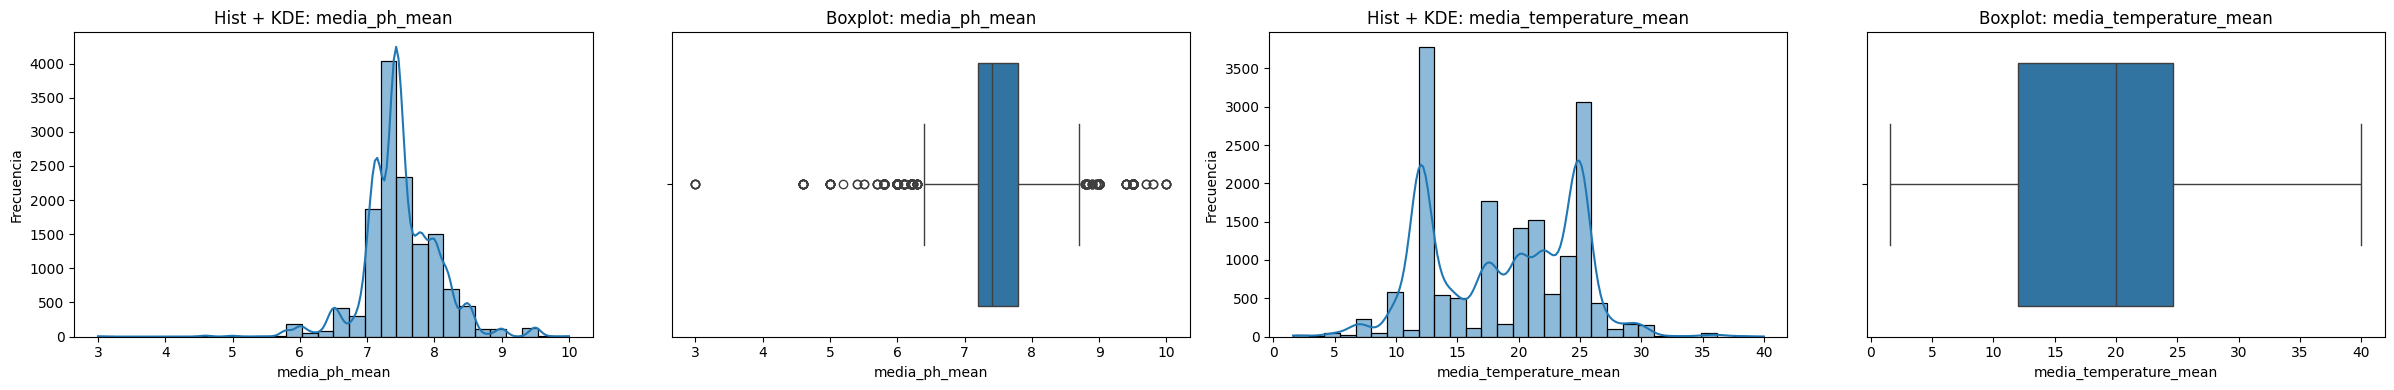

Visualizando grupo: mordred con 26 variables


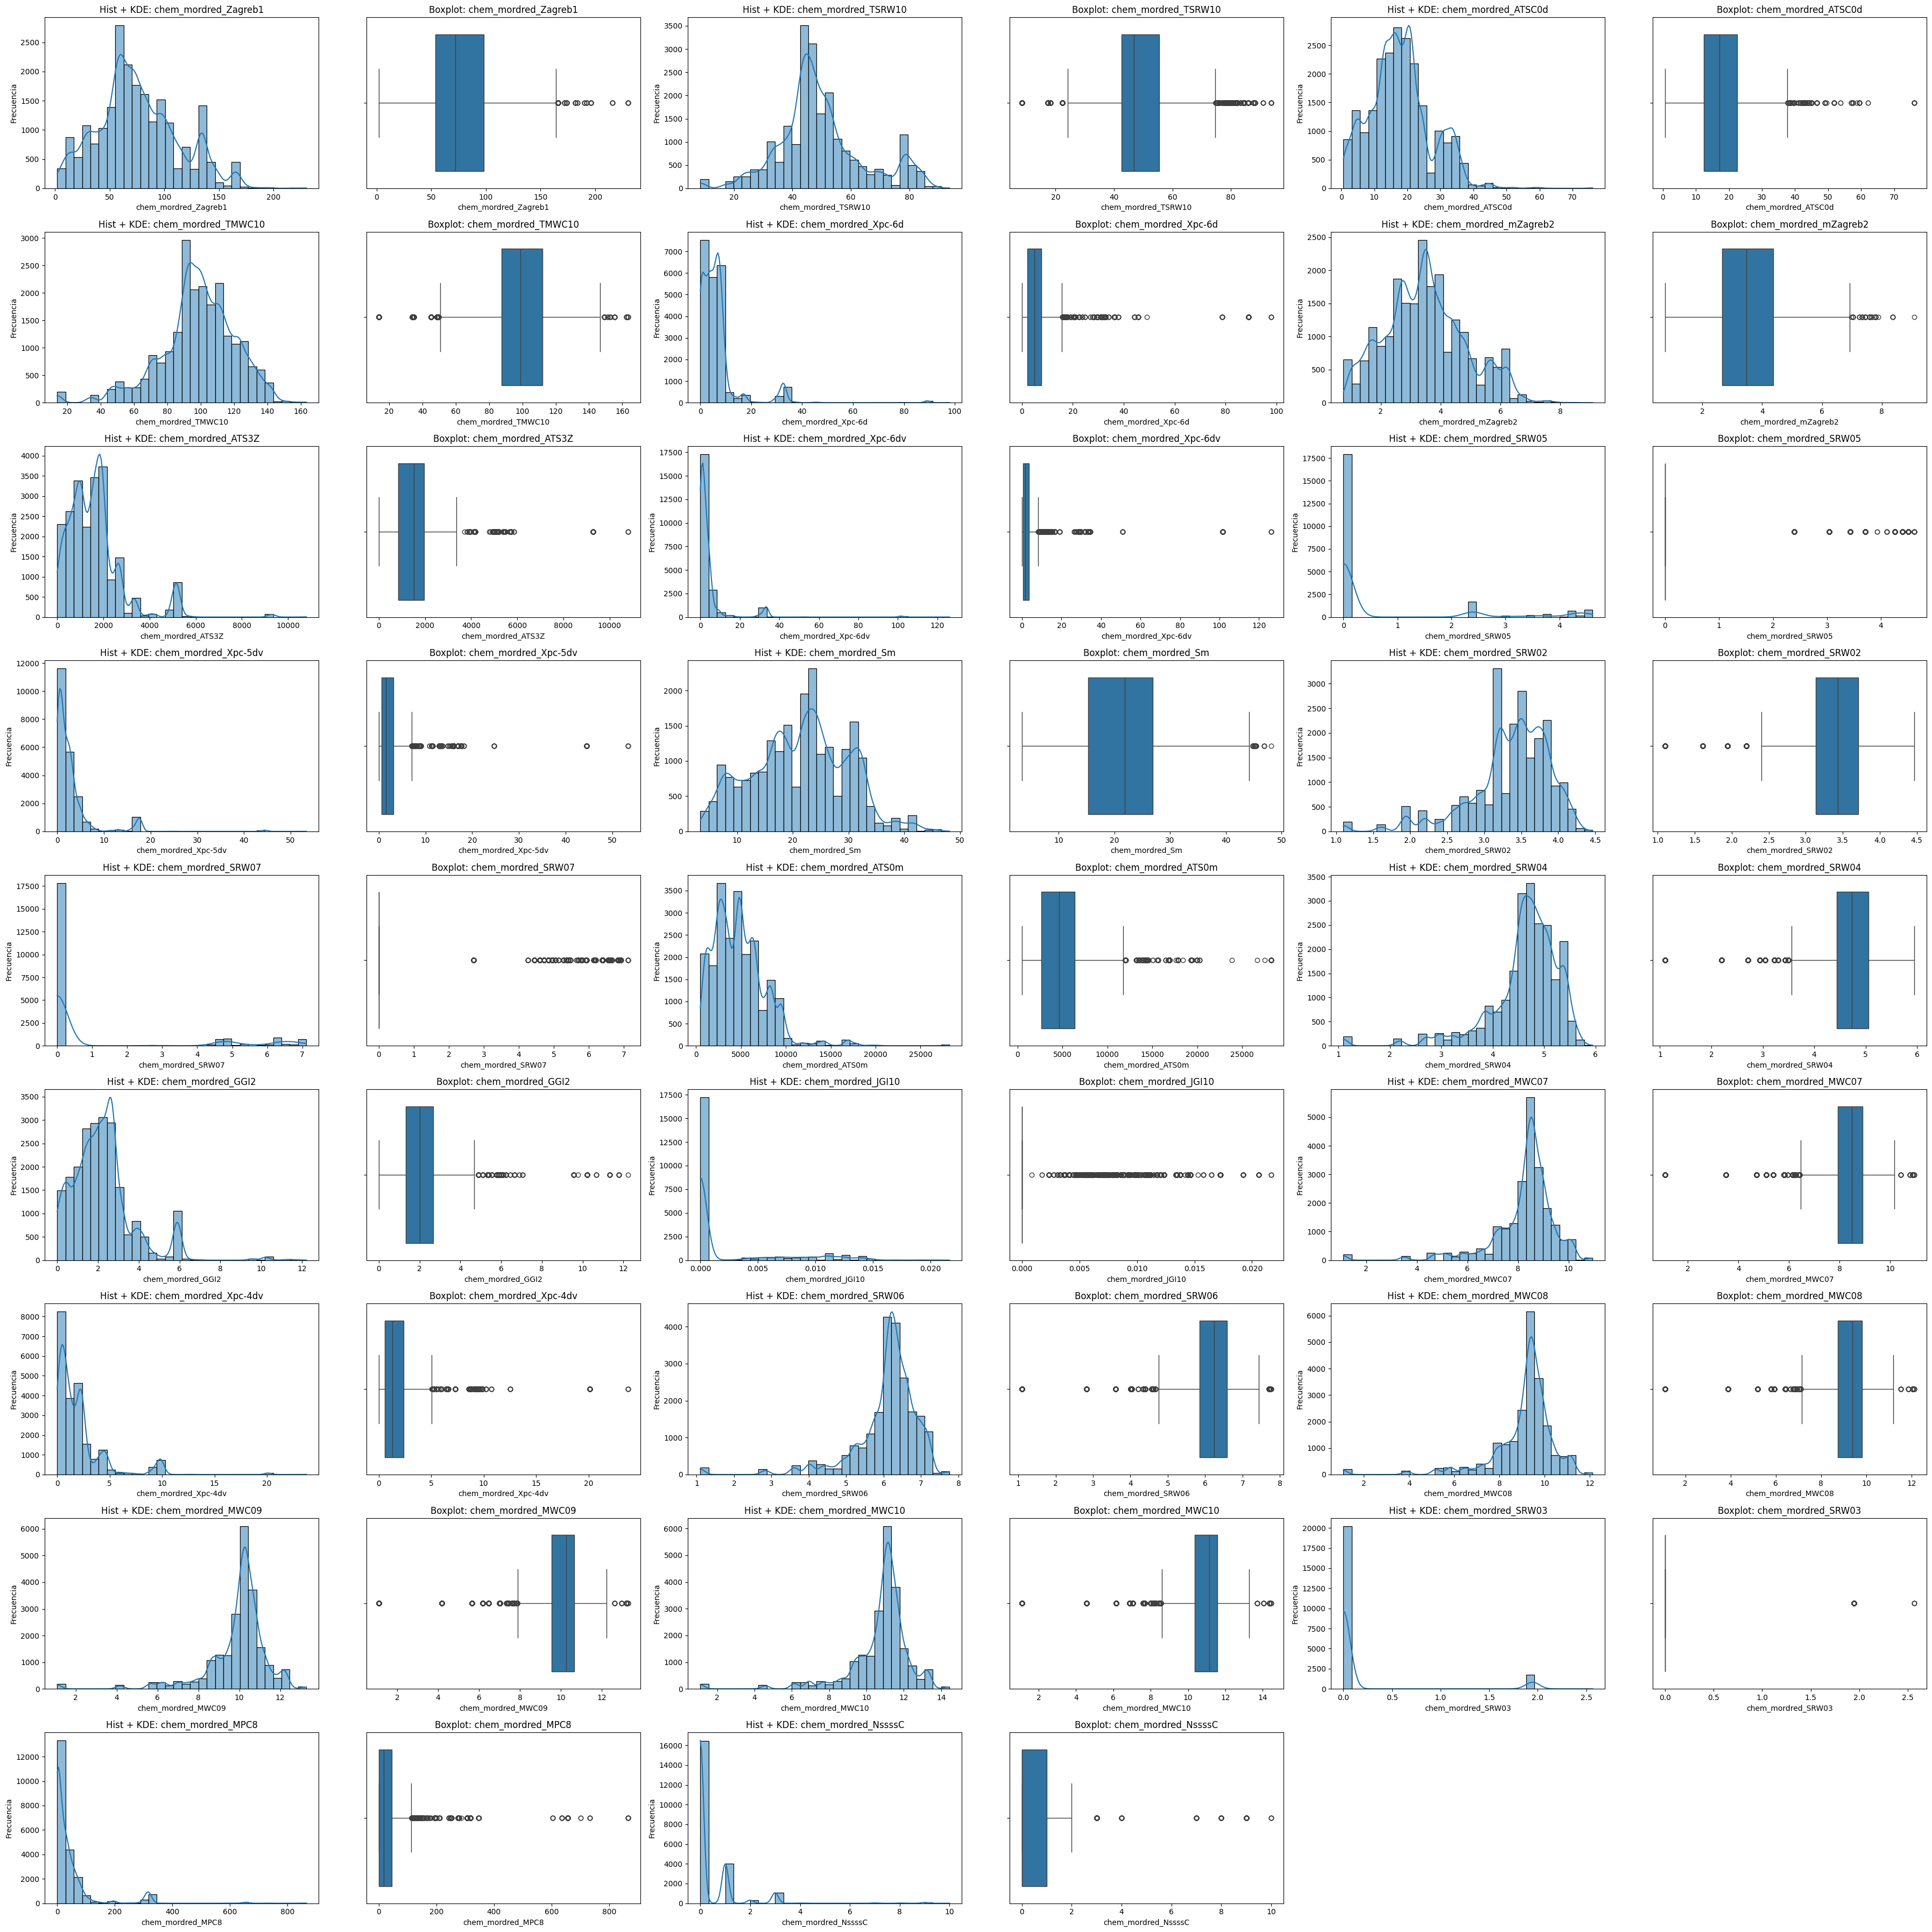

Visualizando grupo: result con 1 variables


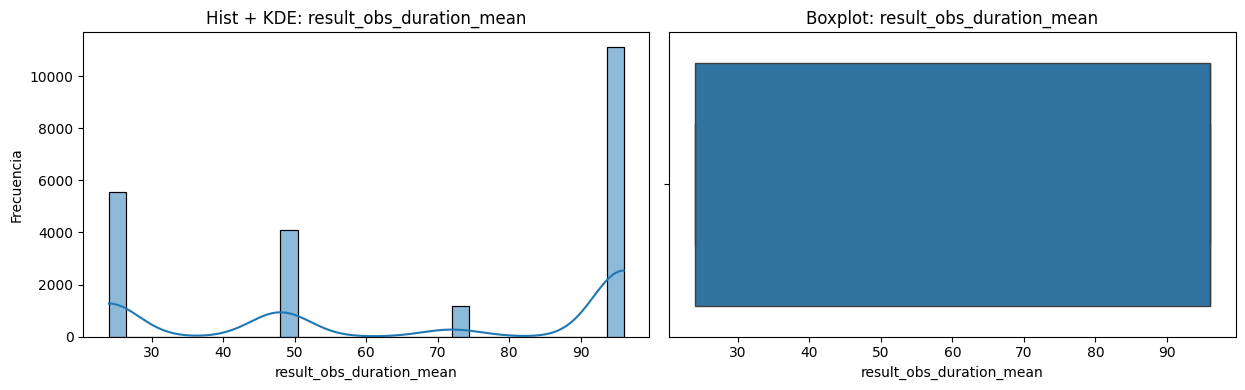

Visualizando grupo: mol2vec con 4 variables


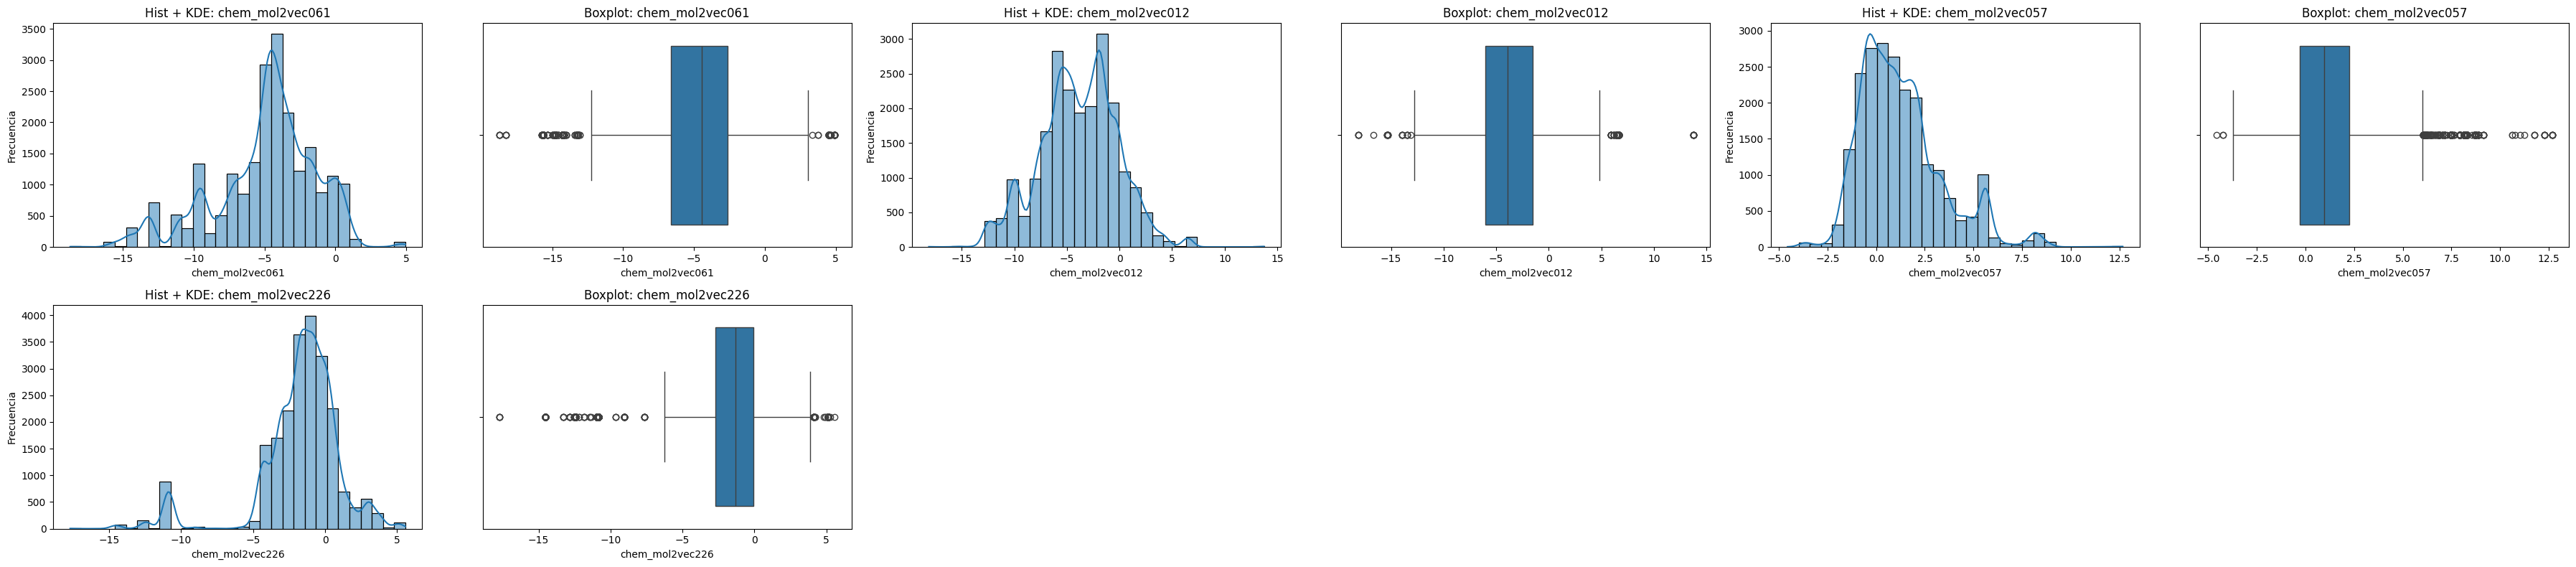

Visualizando grupo: tax con 6 variables


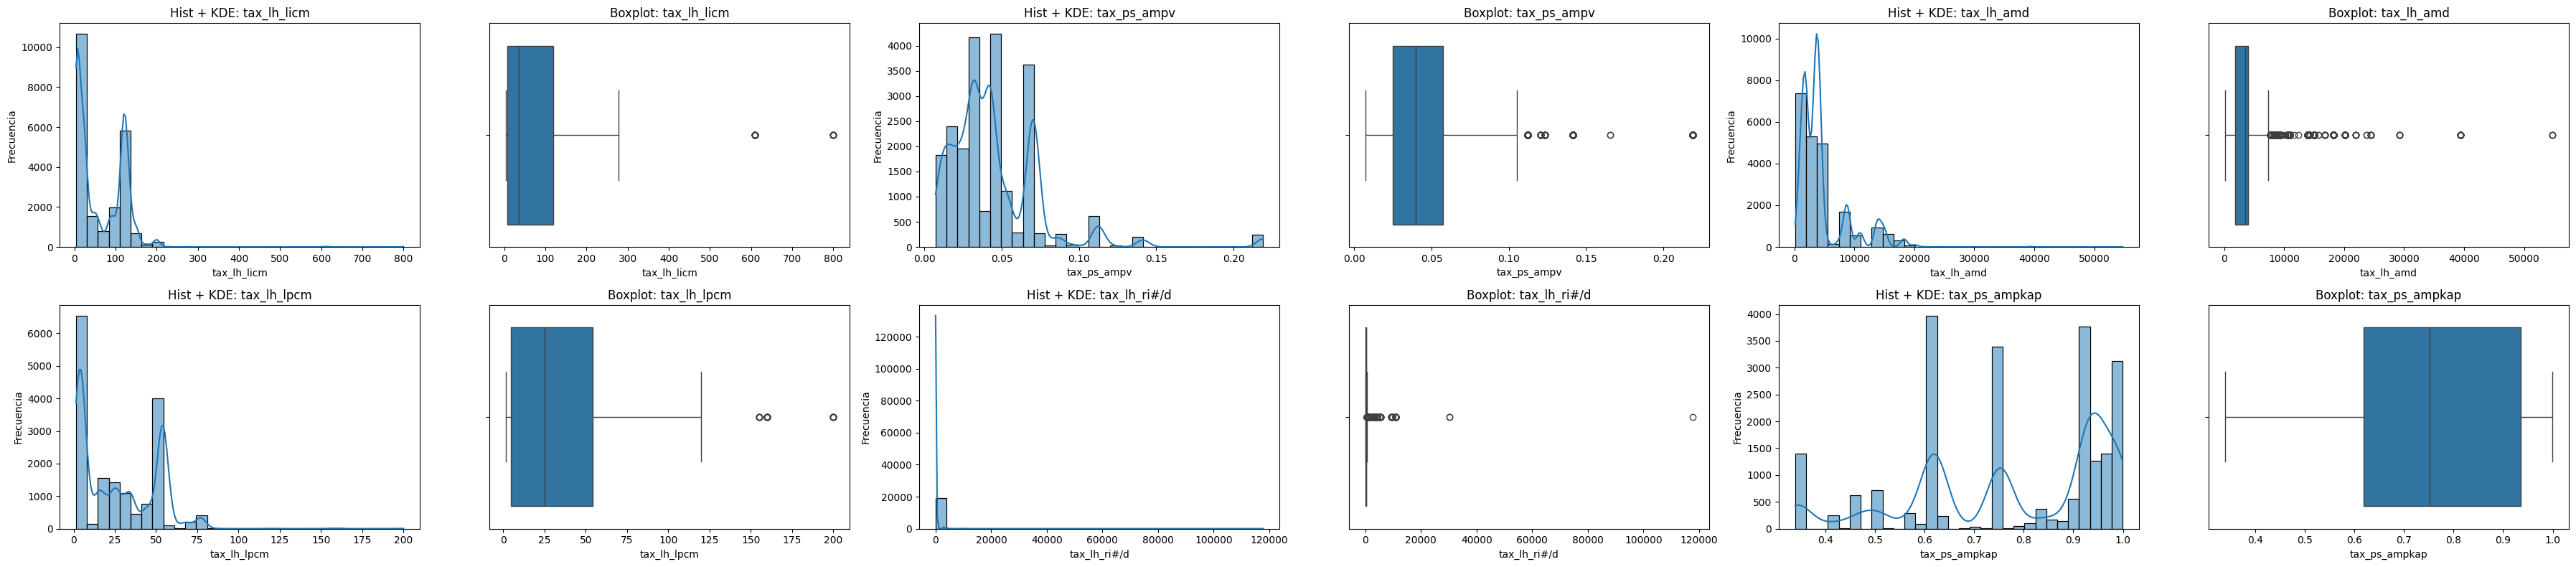

In [42]:
# Visualización
for familia, variables in grupos_variables.items():
    print(f"Visualizando grupo: {familia} con {len(variables)} variables")
    eda.plot_num_univar_grouped(df_modelo, variables, n_cols=3, bins=30)

### Cierre del análisis univariante – Variables numéricas

Tras analizar individualmente las **39 variables numéricas** preseleccionadas, se establecieron las siguientes conclusiones clave para orientar los siguientes pasos del pipeline:

#### Observaciones generales

- La mayoría de variables presentan distribuciones **asimétricas o sesgadas a la derecha**, con outliers frecuentes.
- Algunas variables químicas (`chem_mordred_*`) y taxonómicas (`tax_*`) presentan rangos muy amplios o concentraciones extremas que podrían afectar modelos sensibles a la escala.
- Las variables `mol2vec` (embeddings moleculares) mostraron formas razonablemente estables y **no requieren transformaciones**.

#### Decisiones de preprocesado

- **Transformación logarítmica o raíz cuadrada** recomendada para ~15 variables con sesgo y outliers relevantes.
- **Escalado opcional** (MinMax o StandardScaler) aplicable a unas 13 variables, especialmente para modelos que lo requieren.
- **Binning o categorización** sugerido solo en 2 casos puntuales con distribuciones multimodales.
- Ninguna variable fue eliminada en esta fase, pero se detectaron **posibles redundancias** dentro de familias (`SRW`, `Xpc`, `MWC`, etc.) a revisar tras el análisis de correlaciones.

#### Siguiente paso

A partir de estas decisiones, se realizará un **análisis bivariante frente al target `result_conc1_mean_binary`** para:

- Evaluar el poder predictivo individual de cada variable.
- Detectar relaciones no lineales o patrones relevantes.
- Validar la utilidad real de las variables transformadas.

Este paso permitirá definir un subconjunto óptimo de variables y transformar solo las necesarias antes de proceder con la modelización.


In [43]:
vars_num_analizar

['media_ph_mean',
 'chem_mordred_Zagreb1',
 'chem_mordred_TSRW10',
 'result_obs_duration_mean',
 'media_temperature_mean',
 'chem_mordred_ATSC0d',
 'chem_mol2vec061',
 'chem_mordred_TMWC10',
 'chem_mordred_Xpc-6d',
 'chem_mordred_mZagreb2',
 'chem_mordred_ATS3Z',
 'chem_mol2vec012',
 'chem_mordred_Xpc-6dv',
 'chem_mordred_SRW05',
 'chem_mordred_Xpc-5dv',
 'chem_mordred_Sm',
 'chem_mordred_SRW02',
 'chem_mordred_SRW07',
 'tax_lh_licm',
 'chem_mordred_ATS0m',
 'chem_mordred_SRW04',
 'chem_mordred_GGI2',
 'chem_mordred_JGI10',
 'tax_ps_ampv',
 'chem_mordred_MWC07',
 'chem_mordred_Xpc-4dv',
 'chem_mordred_SRW06',
 'chem_mordred_MWC08',
 'tax_lh_amd',
 'tax_lh_lpcm',
 'chem_mordred_MWC09',
 'tax_lh_ri#/d',
 'chem_mordred_MWC10',
 'chem_mordred_SRW03',
 'tax_ps_ampkap',
 'chem_mol2vec057',
 'chem_mol2vec226',
 'chem_mordred_MPC8',
 'chem_mordred_NssssC']

In [44]:
# Crear el DataFrame con variables numéricas a analizar + target
df_modelo[target] = y_train.copy()

print(df_modelo.shape)  # debería mostrar (n_filas, 40) -> 39 features + 1 target
df_modelo.columns.tolist()[-1]  # debería ser 'result_conc1_mean_binary'

(21981, 40)


'result_conc1_mean_binary'

## Variables categoricas
[Indice](#indice)

In [45]:
# Selección de variables categóricas relevantes
vars_cat_analizar = [var for var in vars_analizar_ordenadas if var in vars_categoricas]
print(f"Número de variables categóricas a analizar: {len(vars_cat_analizar)}")

Número de variables categóricas a analizar: 6


In [46]:
# Añadirlas a df_modelo desde X_train_validadas
df_modelo = pd.concat([
    df_modelo,
    X_train_validadas[vars_cat_analizar]
], axis=1)

# Verificación
print(df_modelo.shape)
df_modelo[vars_cat_analizar].head()

(21981, 46)


,tax_gs,test_exposure_type,test_organism_lifestage,result_endpoint,tax_family,tax_eco_migrate2
0,Cyprinus_carpio,S,NR,LC50,Cyprinidae,migration
1,Cyprinus_carpio,S,NR,LC50,Cyprinidae,migration
2,Cyprinus_carpio,S,NR,LC50,Cyprinidae,migration
3,Cyprinus_carpio,S,NR,LC50,Cyprinidae,migration
4,Cyprinus_carpio,S,NR,LC50,Cyprinidae,migration


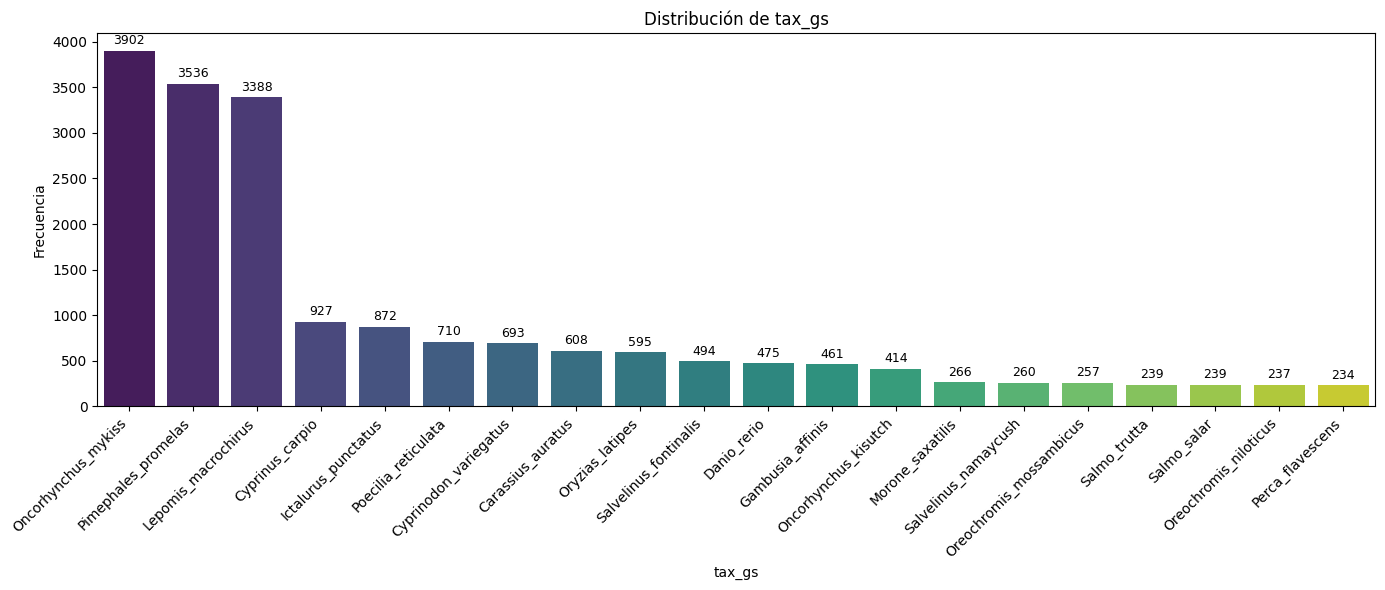

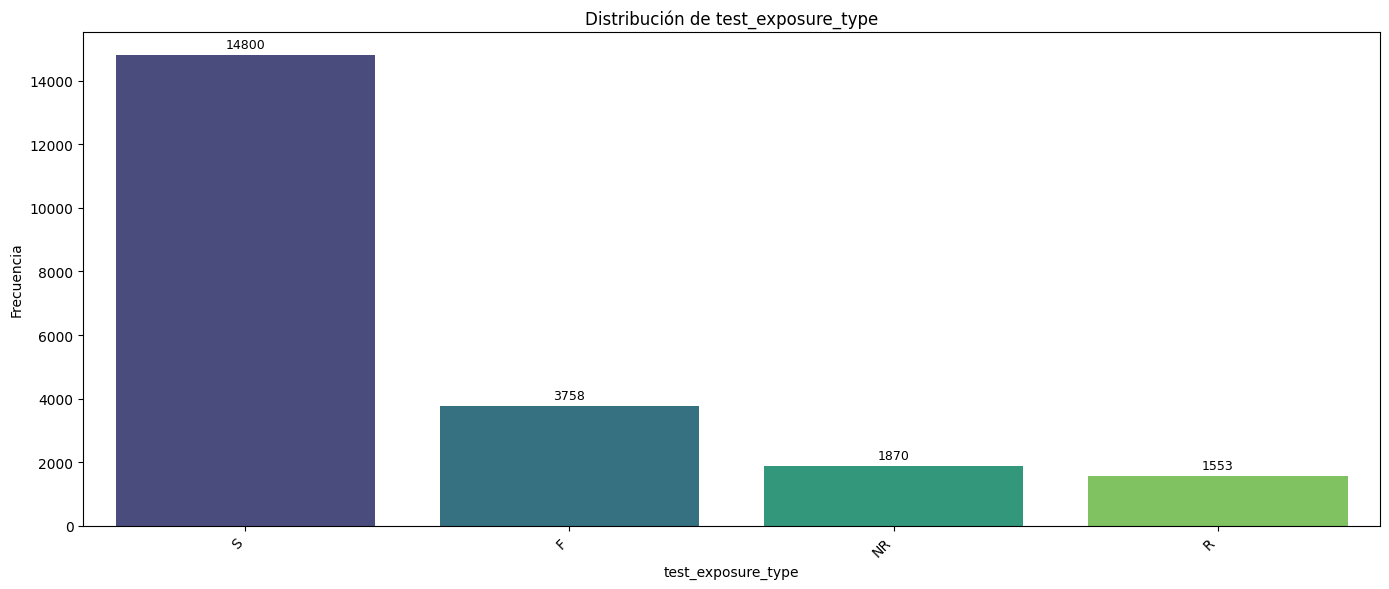

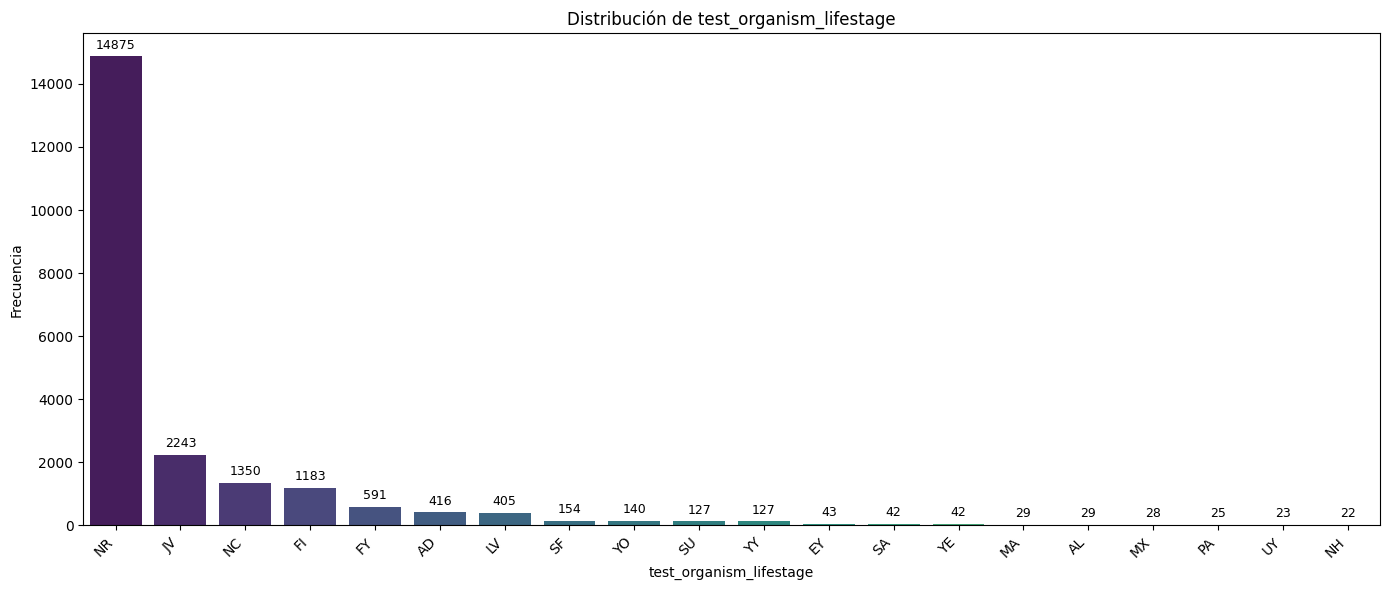

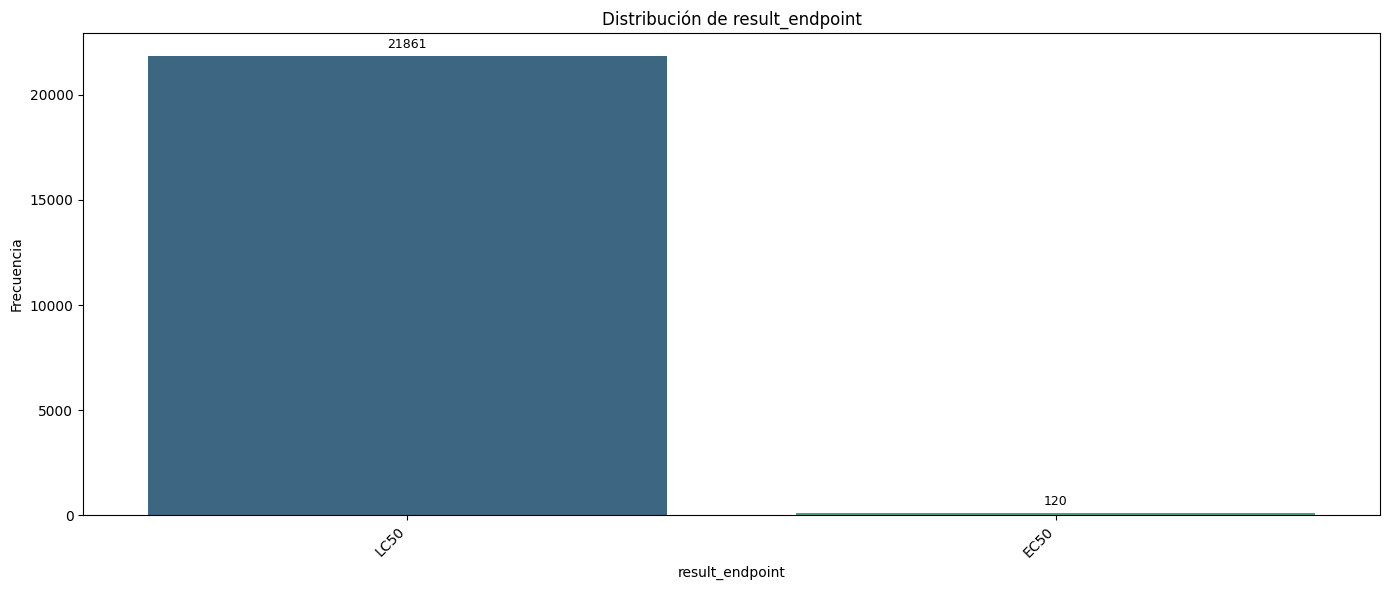

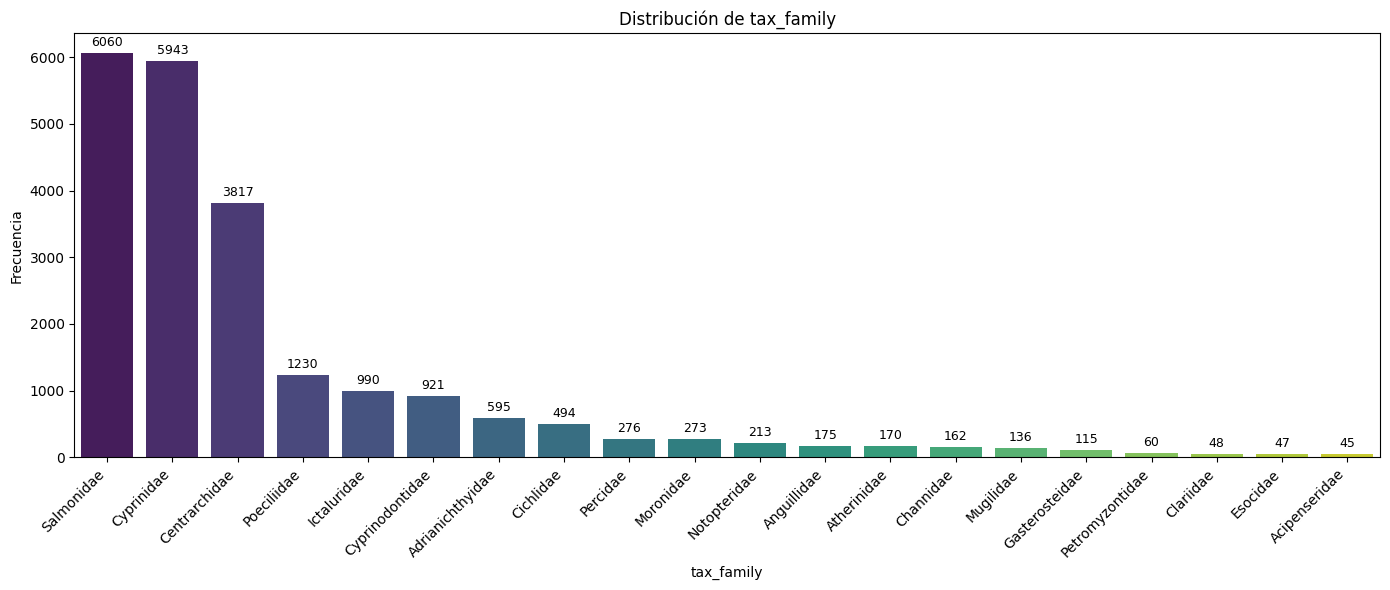

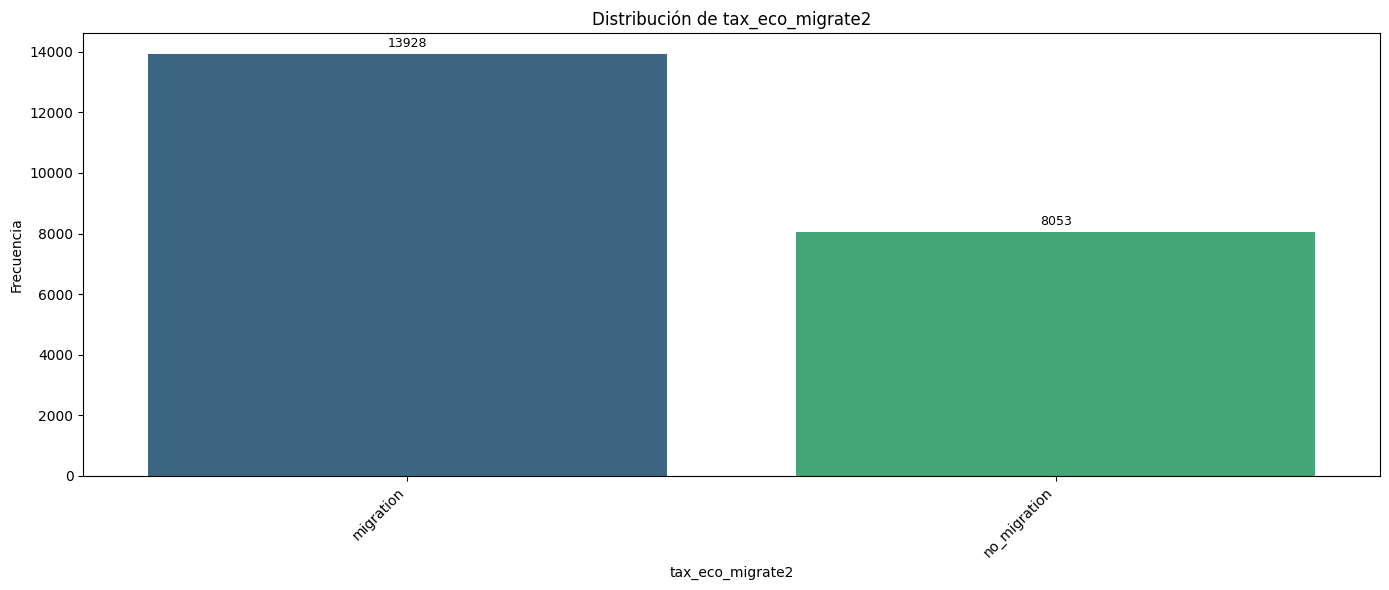

In [47]:
# Visualización univariante
eda.plot_cat_univar(X_train_validadas, vars=vars_cat_analizar, top=20, show_values=True)

### Nota de trazabilidad – Exclusión de `chem_mordred_MWC01`

Durante la integración de rankings de importancia (Random Forest y SelectKBest), se identificó que la variable `chem_mordred_MWC01` figuraba entre las top 20 de Random Forest por importancia agregada.

Sin embargo, esta variable **no se encontraba en el conjunto validado `X_train_validadas`**. Tras revisar la plantilla de análisis (`plantilla_analisis_final.csv`), se comprobó que había sido previamente **marcada como `duplicada` y eliminada** durante la fase de reducción estructural de features.

In [48]:
# Detectar la variable que está en el ranking pero no se clasificó como numérica ni categórica
set_total = set(vars_analizar_ordenadas)
set_analizadas = set(vars_num_analizar + vars_cat_analizar)
faltante = set_total - set_analizadas

print(f"Variable no clasificada: {faltante}")

Variable no clasificada: {'chem_mordred_MWC01'}


In [49]:
plantilla_analisis.query("nombre_variable == 'chem_mordred_MWC01'")

,nombre_variable,tipo_sugerido,segmento,expectativas,conclusion,grupo_expectativa,importancia
1066,chem_mordred_MWC01,Numérica Discreta,químico,duplicada,eliminar,duplicada,NaN


# Analisis Bivariante
[Indice](#indice)

## Variables numericas vs. target

Tras el análisis univariante, se han clasificado las 39 variables numéricas en cinco familias funcionales en función de su naturaleza y origen:

| Familia         | Descripción                                                                 |
|-----------------|------------------------------------------------------------------------------|
| `chem_mordred`  | Descriptores moleculares clásicos calculados con Mordred                   |
| `chem_mol2vec`  | Embeddings vectoriales a partir de representaciones SMILES (`mol2vec`)     |
| `tax`           | Variables taxonómicas (distancias filogenéticas, diversidad, conservación) |
| `media`         | Condiciones experimentales  (pH, temperatura)                         |
| `result`        | Duración de los ensayos de toxicidad                                       |

Esta clasificación nos permite organizar el análisis bivariante de forma más eficiente, y detectar patrones diferenciados según el tipo de variable:

- Los **descriptores `chem_mordred`** suelen requerir transformación logarítmica o escalado, pero pueden ser informativos si se alinean con mecanismos moleculares de toxicidad.
- Las variables `mol2vec` ya están estandarizadas y pueden evaluarse sin transformación.
- Las **variables taxonómicas** reflejan propiedades del organismo expuesto, como su filogenia o tolerancia, y podrían ser muy predictivas.
- Las variables de tipo `media` y `result` son contextuales del experimento y pueden actuar como modificadores o confundidores.


### Objetivo de este análisis

Evaluar, para cada variable, su **relación con el target binario** `result_conc1_mean_binary`, mediante:

- Visualización de su distribución según clase del target (usando violinplots o boxplots).
- Comparación de medias/medianas por clase.
- Cálculo de métricas estadísticas relevantes (por ejemplo: ANOVA, U de Mann-Whitney, AUC, etc.).

Esto nos permitirá:

- Detectar variables con potencial predictivo individual.
- Verificar si las transformaciones realizadas mejoran la separabilidad.
- Descartar variables que no aporten información relevante.


>Colores:
    🔴 cumple AUC y p-valor
    🟡 solo p-valor significativo
    🔵 solo AUC alto
    ⚫ no destaca


 Analizando grupo: media


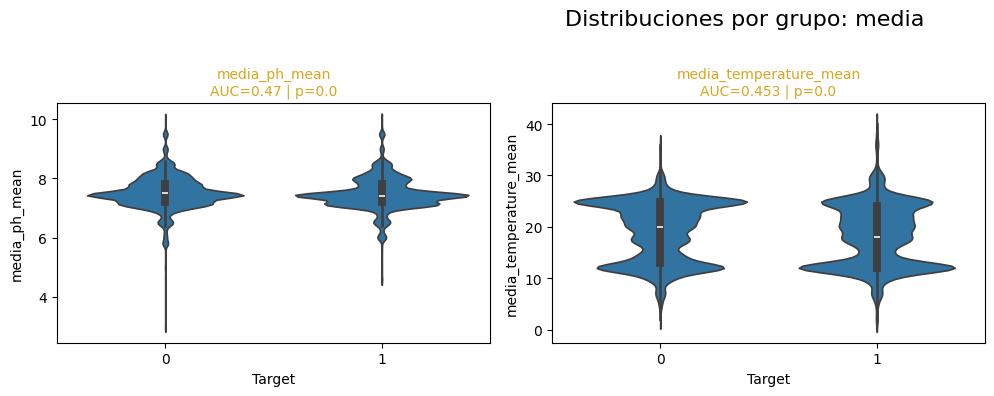


 Analizando grupo: mordred


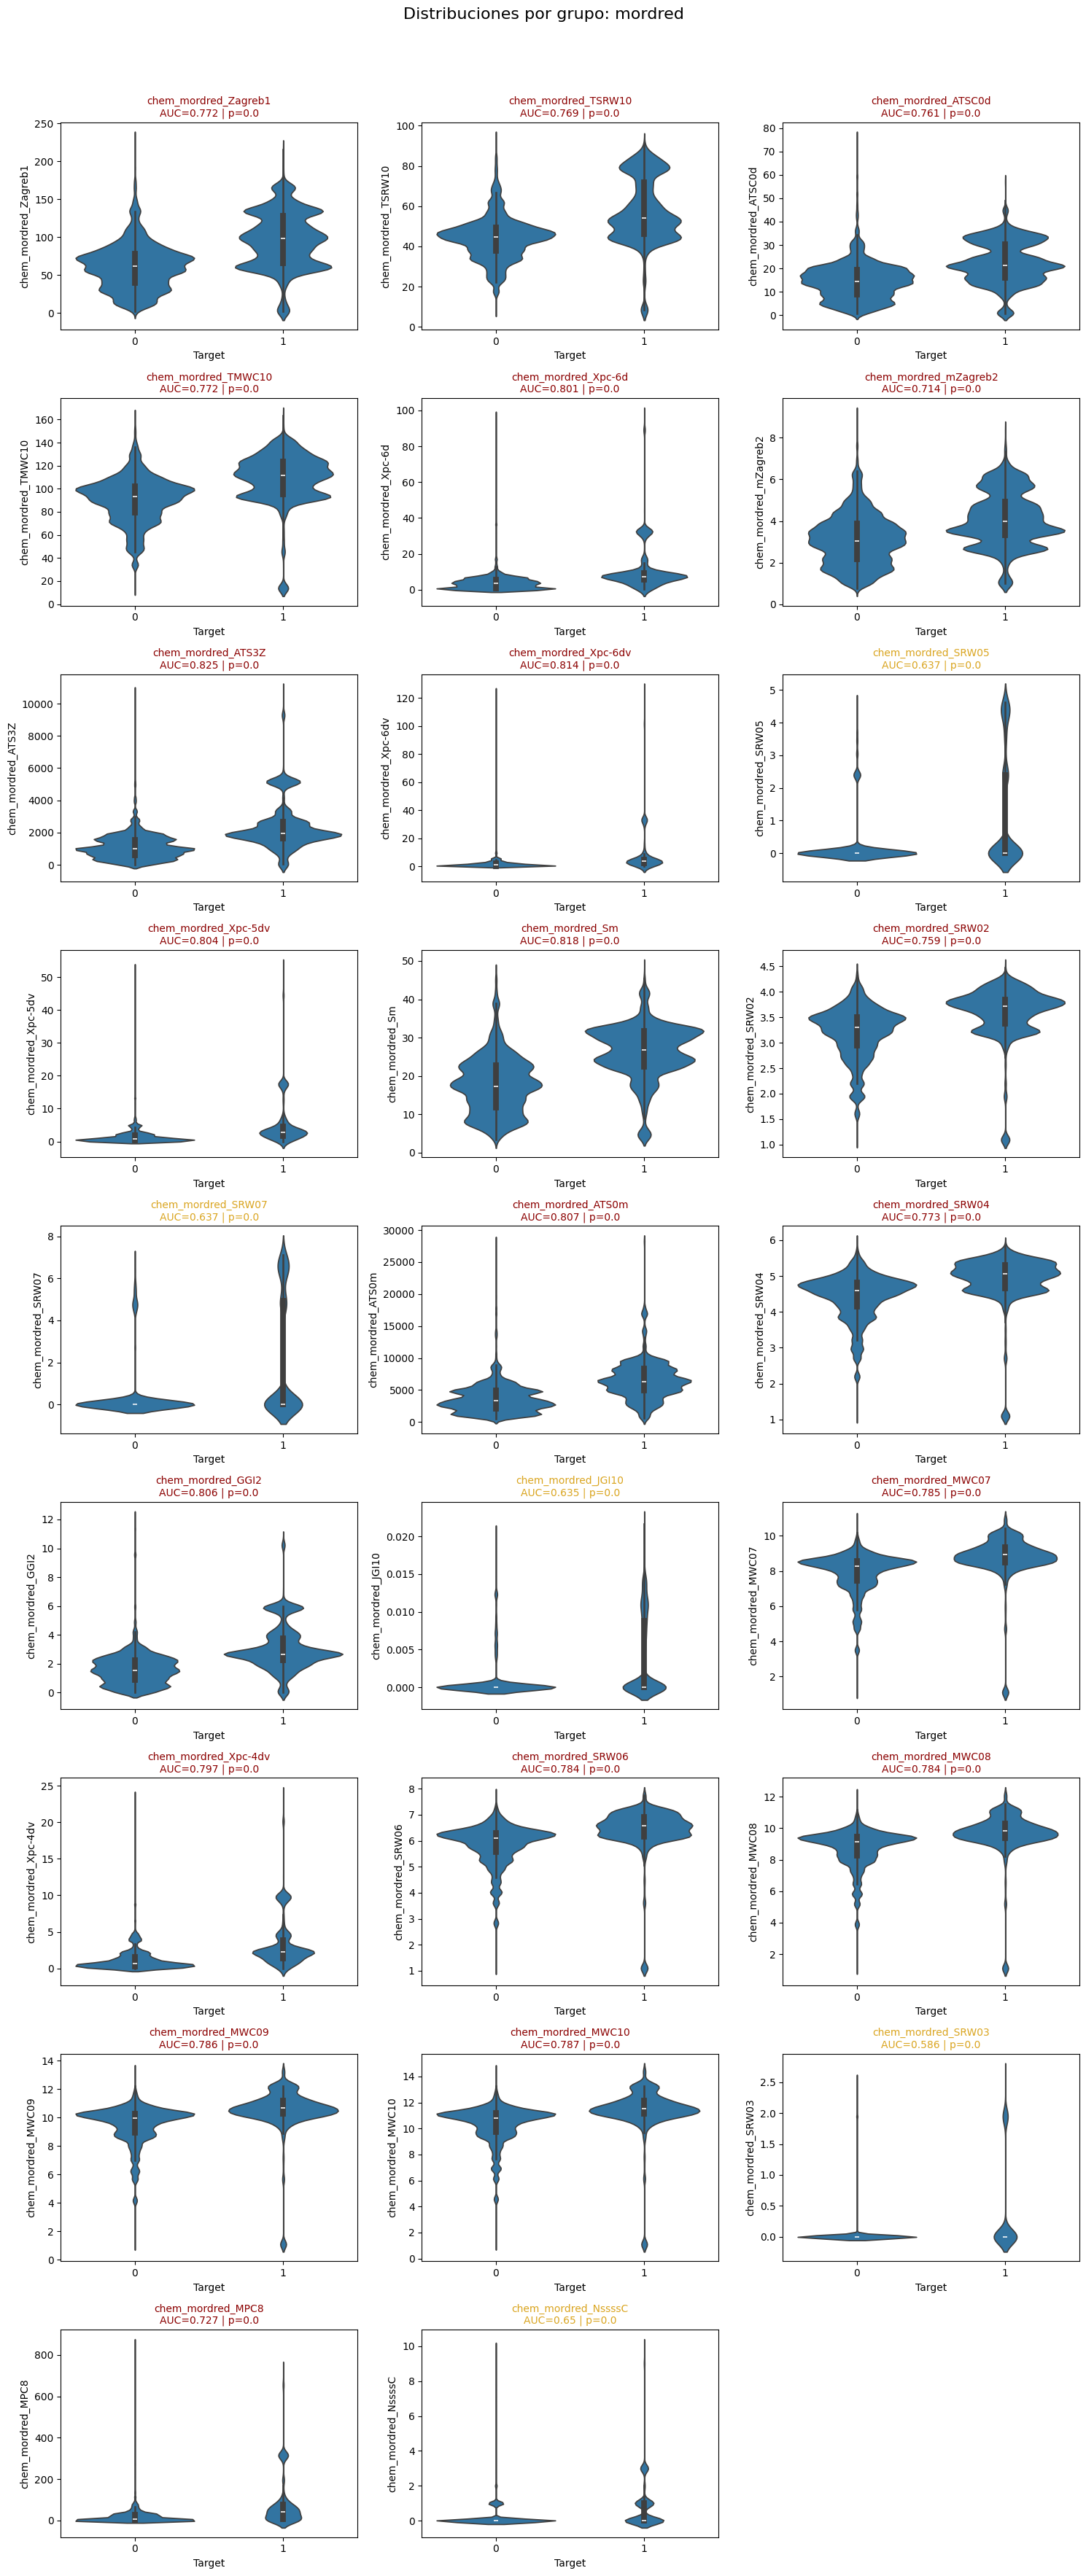


 Analizando grupo: result


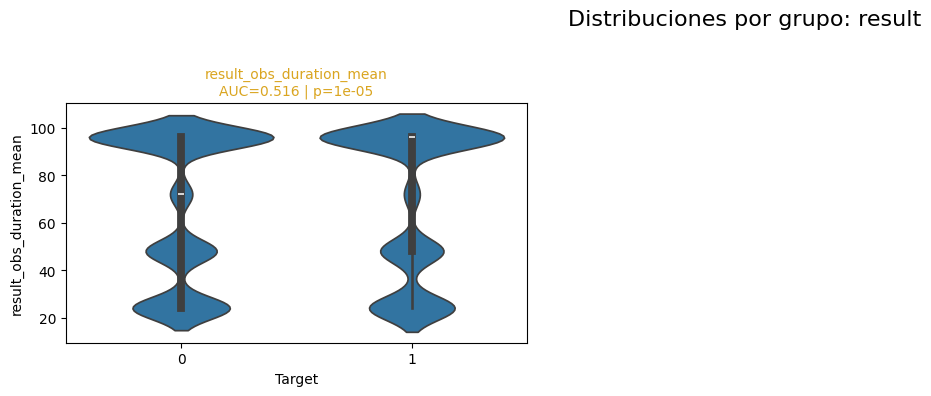


 Analizando grupo: mol2vec


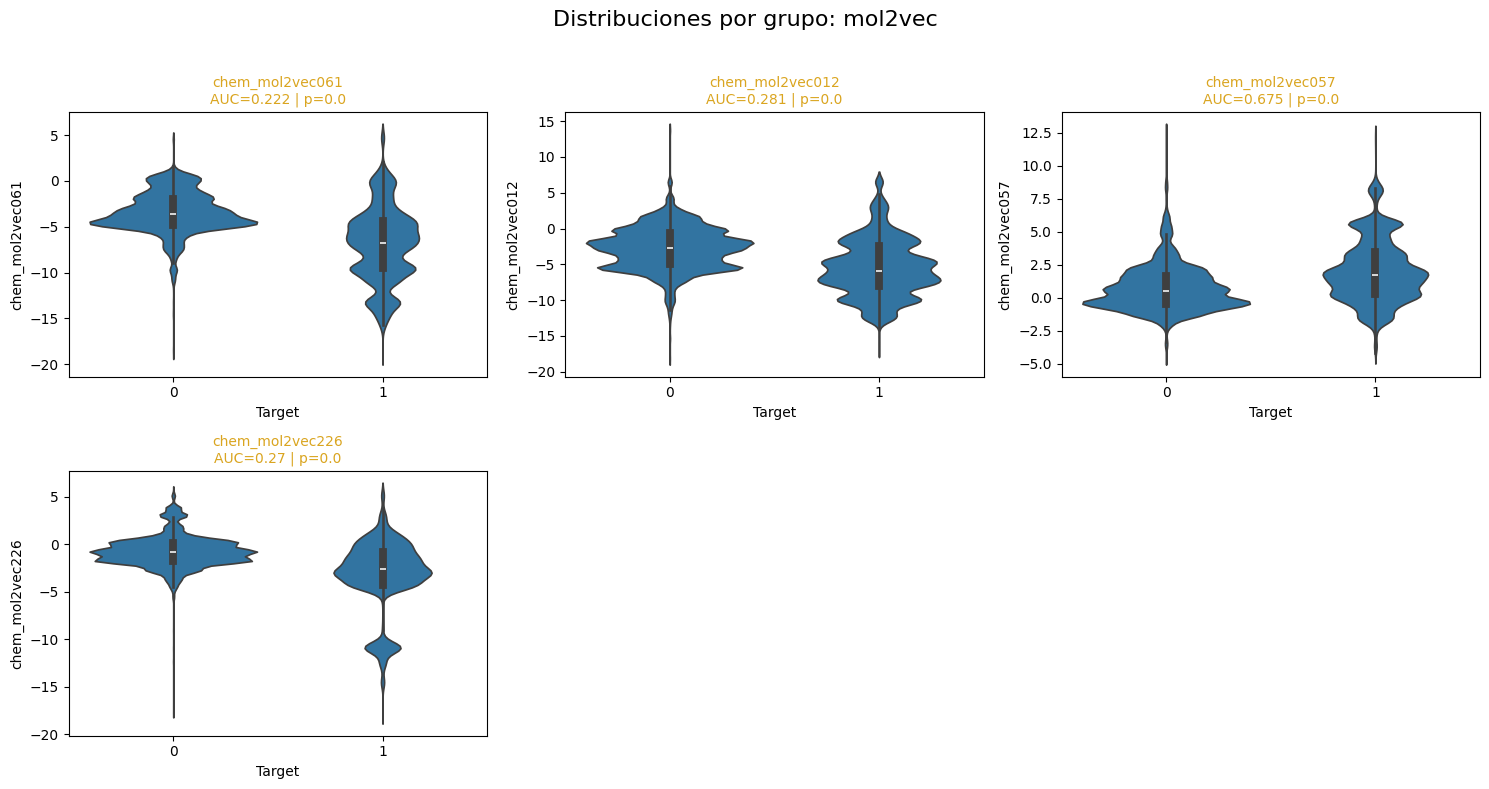


 Analizando grupo: tax


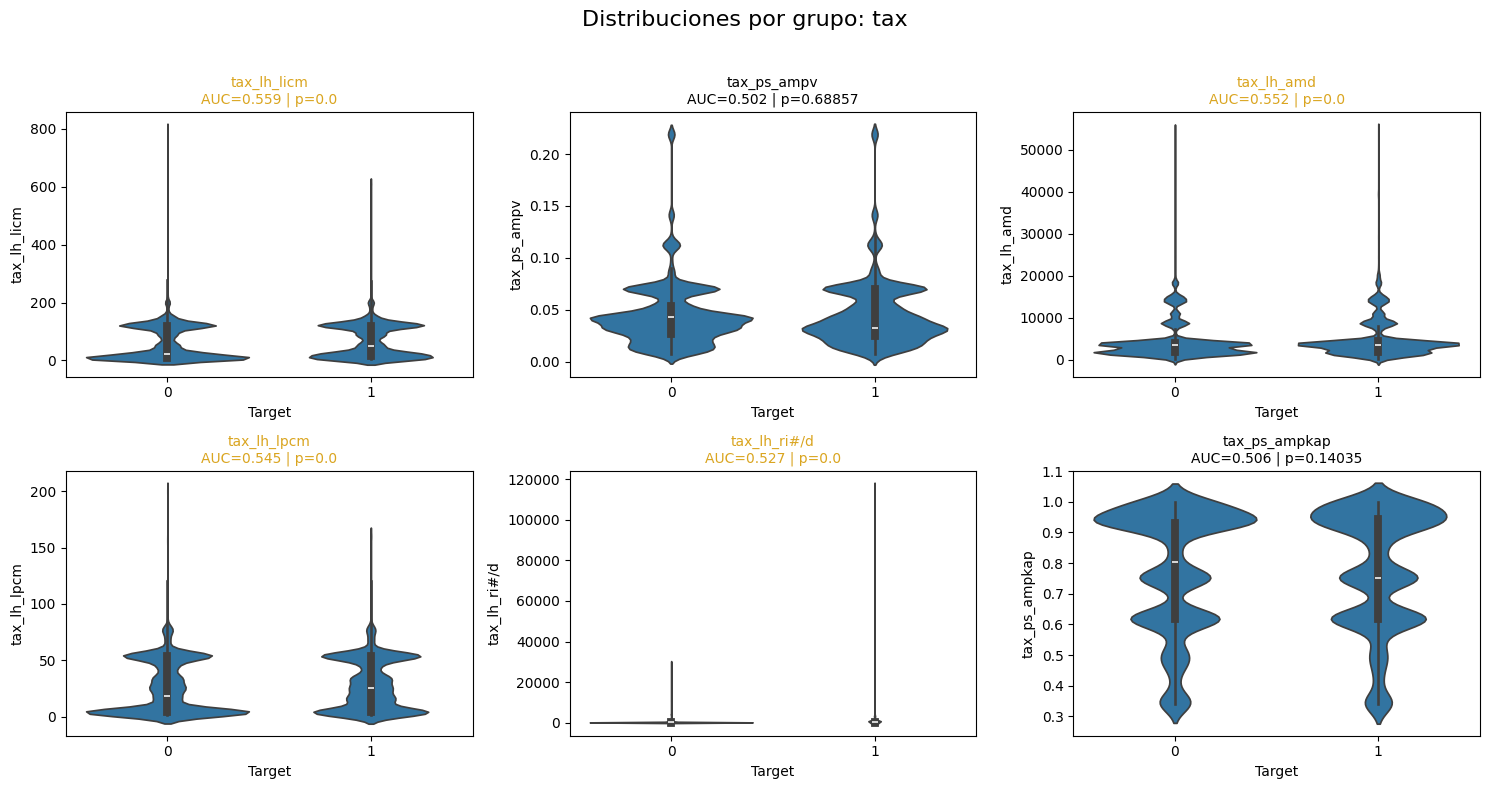

In [50]:
# Inicializar un DataFrame vacío para acumular resultados
resultados_bivariantes = pd.DataFrame()

# Iterar por cada grupo (familia)
for familia, variables in grupos_variables.items():
    print(f"\n Analizando grupo: {familia}")
    
    # 1. Análisis bivariante con métricas
    resultados = eda.analisis_bivariante_grupo(
        df=df_modelo,
        variables=variables,
        target="result_conc1_mean_binary",
        group_name=familia, 
        plot=False  # desactiva los plots individuales
    )
    
    #2. Acumular resultados
    resultados_bivariantes = pd.concat([resultados_bivariantes, resultados], ignore_index=True)
    
    # 3. Mostrar violinplots agrupados con AUC y p-valor
    eda.plot_violin_grouped(
        df=df_modelo,
        variables=variables,
        target="result_conc1_mean_binary",
        group_name=familia,
        df_resultados=resultados,
        auc_threshold=0.7,            
        pval_threshold=0.05
)

### Conclusiones preliminares del análisis bivariante

Análisis realizado sobre 39 variables frente al target binario (`result_conc1_mean_binary`), agrupadas por funcionalidad. Evaluación basada en:  
- AUC (Area Under Curve)
- p-valor de test estadístico
- Forma de la distribución (violin plots)


#### 1. Grupo `media` – Condiciones experimentales

Variables:  
- `media_ph_mean`, `media_temperature_mean`

Ambas variables muestran p-valor significativo pero AUC < 0.5, con distribuciones casi idénticas entre clases.

**Conclusión**: No aportan señal predictiva → **Descartar**

#### 2. Grupo `mordred` – Descriptores moleculares

Es el grupo más informativo. Se identifican múltiples variables con AUC > 0.75 y buena separación visual:

**Variables destacadas (para conservar):**  
- `Zagreb1`, `TSRW10`, `ATSC0d`, `TMWC10`, `Xpc-6d`, `mZagreb2`, `ATS3Z` ,`Xpc-6dv`, `Xpc-5dv`, `Sm`,  
  `SRW02`, `ATS0m`,  `SRW04`, `GGI2`, `MWC07`, `Xpc-4dv` , `SRW06`, `MWC08`, `MWC09`, `MWC10`, `MPC8`
        

**Variables con AUC bajo o nula separación (para descartar):**  
- `SRW03`, `SRW05`, `SRW07`, `JGI10`, `NssssC`

**Conclusión**: El grupo aporta el grueso de las features candidatas.  
Se recomienda revisar colinealidad entre variables similares (ej. MWC*, Xpc*).

#### 3. Grupo `result` – Duración de observación

Variable:  
- `result_obs_duration_mean`

AUC ≈ 0.51, p-valor significativo pero sin diferencia visual clara.

**Conclusión**: Variable irrelevante → **Descartar**

#### 4. Grupo `mol2vec` – Embeddings moleculares

Variables:  
- `mol2vec057`, `mol2vec012`, `mol2vec061`, `mol2vec226`

Solo `mol2vec057` muestra una separación moderada (AUC ≈ 0.675).  
El resto tienen AUC < 0.3, a pesar del p-valor.

**Conclusión**:  
- Conservar: `mol2vec057`  
- Descartar: `mol2vec012`, `mol2vec061`, `mol2vec226`

### 5. Grupo `tax` – Variables taxonómicas

Variables:  
- `tax_lh_licm`, `tax_lh_amd`, `tax_lh_lpcm`, `tax_lh_ri#/d`, `tax_ps_ampv`, `tax_ps_ampkap`

Todas con AUC entre 0.50 y 0.56, sin separación útil.

**Conclusión**: No aportan valor predictivo → **Descartar**

In [51]:
# Variables candidatas a conservar 
# Variables candidatas a conservar (corregidas)
features_preseleccionadas = [
    "chem_mordred_Zagreb1",
    "chem_mordred_TSRW10",
    "chem_mordred_ATSC0d",
    "chem_mordred_TMWC10",
    "chem_mordred_mZagreb2",
    "chem_mordred_ATS3Z",        # corregido
    "chem_mordred_Xpc-6dv",
    "chem_mordred_Xpc-5dv",
    "chem_mordred_Xpc-6d",
    "chem_mordred_Sm",
    "chem_mordred_SRW02",
    "chem_mordred_SRW04",
    "chem_mordred_SRW06",
    "chem_mordred_MWC07",
    "chem_mordred_MWC08",
    "chem_mordred_MWC09",
    "chem_mordred_MWC10",
    "chem_mordred_ATS0m",
    "chem_mordred_GGI2",
    "chem_mordred_MPC8",        # corregido
    "chem_mol2vec057"
]


### Subconjunto de variables contextuales no predictivas

Aunque muchas variables taxonómicas (`tax_*`) y experimentales (`media_*`, `result_*`) no mostraron una relación bivariante significativa con el target, podrían aportar valor indirecto en modelos más complejos. Por ejemplo:

- Introduciendo **contexto ambiental o biológico**.
- Capturando **interacciones sutiles** con descriptores moleculares.
- Mejorando la **capacidad de generalización** si el modelo se entrena con muestras diversas.

#### ¿Por qué conservar algunas variables contextuales?

- Estas variables no son predictoras fuertes por sí solas (AUC bajo),  
  pero pueden **ayudar al modelo a adaptarse a condiciones específicas** (especie, temperatura, pH).
- Son especialmente útiles en tareas donde se acepta cierto grado de **ajuste al contexto** más que generalización pura.
- Su valor se puede evaluar empíricamente en una segunda etapa con validación cruzada.

In [52]:
features_contextuales = [
    "media_ph_mean",               # condiciones ambientales
    "media_temperature_mean",
    "tax_lh_licm",                 # medidas taxonómicas/filogenéticas
    "tax_lh_amd",
    "tax_lh_lpcm",
    "tax_lh_ri#/d"
]

### Colinealidad
[Indice](#indice)

Una vez completado el análisis univariante y bivariante, se procede a revisar la colinealidad entre las variables numéricas seleccionadas. La colinealidad (o multicolinealidad) se refiere a la presencia de fuertes correlaciones entre pares de variables, lo que puede provocar inestabilidad en los modelos de machine learning, especialmente aquellos basados en coeficientes (e.g., regresión logística).

En este análisis:

- Se calcula la matriz de correlación de Pearson entre todas las variables numéricas del dataset modelable (`df_modelo`).
- Se identifican pares con correlación absoluta mayor o igual a `0.9`.
- Para cada par correlacionado, se sugiere eliminar la variable menos útil según el criterio de mayor `AUC univariado`, obtenido del análisis bivariante.

Este procedimiento permite reducir la redundancia informativa y prevenir sobreajuste, conservando aquellas variables con mayor poder predictivo individual.

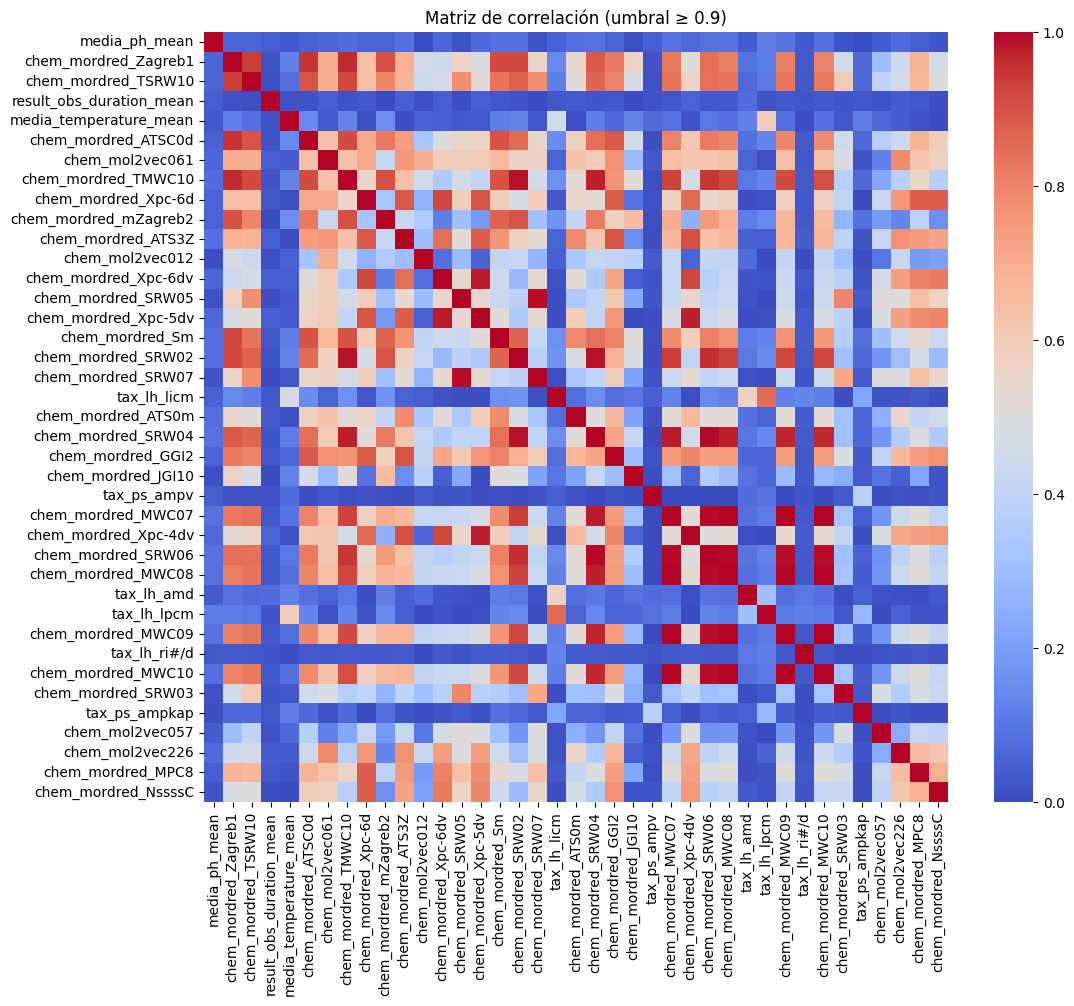

,Variable 1,Variable 2,Correlación
42,chem_mordred_MWC09,chem_mordred_MWC10,0.999765
40,chem_mordred_MWC08,chem_mordred_MWC09,0.999753
34,chem_mordred_MWC07,chem_mordred_MWC08,0.999597
41,chem_mordred_MWC08,chem_mordred_MWC10,0.999518
35,chem_mordred_MWC07,chem_mordred_MWC09,0.999289
36,chem_mordred_MWC07,chem_mordred_MWC10,0.998443
33,chem_mordred_MWC07,chem_mordred_SRW06,0.994586
37,chem_mordred_SRW06,chem_mordred_MWC08,0.993379
29,chem_mordred_SRW04,chem_mordred_SRW06,0.992328
38,chem_mordred_SRW06,chem_mordred_MWC09,0.991040


In [53]:
# Ejecutar análisis de colinealidad
df_pares_colineales = eda.analizar_colinealidad(
    df=df_modelo,
    variables=vars_num_analizar,
    umbral=0.9,
    mostrar_heatmap=True
)

# Mostrar resultados si hay
if df_pares_colineales.empty:
    print("No se encontraron pares colineales con ese umbral.")
else:
    display(df_pares_colineales)

#### Alta colinealidad en el grupo `chem_mordred`

Como se observa en la matriz de correlación, la gran mayoría de las relaciones altamente colineales se concentran en el grupo de variables `chem_mordred`. Esto es esperable, ya que estos descriptores moleculares computados por el paquete Mordred incluyen medidas derivadas, transformaciones y combinaciones que suelen solaparse en la información que capturan.

Por esta razón, se aplica un proceso selectivo para conservar solo una variable representativa por clúster de colinealidad. El criterio de elección es el `AUC univariado`, favoreciendo la variable con mayor capacidad predictiva frente al target (`result_conc1_mean_binary`).

#### Sugerencia de variables a eliminar por colinealidad

A continuación se muestra una tabla resumen con las parejas altamente correlacionadas (|r| ≥ 0.9), el valor de AUC univariado de cada una y la variable sugerida para eliminar. Esta sugerencia se basa exclusivamente en el criterio de retener aquella con mayor AUC univariado.

Esta decisión puede ser refinada manualmente si existen razones de interpretabilidad, dominio del negocio o validación experimental.

In [54]:
# Generar sugerencias para limpieza de colinealidad
df_log_colinealidad, variables_a_eliminar = eda.sugerir_variables_a_eliminar_opt(
    df_pares_correlados=df_pares_colineales,
    df_resultados=resultados_bivariantes,
    criterio="AUC_univariado"
)

# Visualizar log explicativo
display(df_log_colinealidad)

# Lista final única
print("Variables a eliminar:", variables_a_eliminar)

,Variable_1,Variable_2,Correlación,AUC_univariado_chem_mordred_MWC09,AUC_univariado_chem_mordred_MWC10,A_eliminar,AUC_univariado_chem_mordred_MWC08,AUC_univariado_chem_mordred_MWC07,AUC_univariado_chem_mordred_SRW06,AUC_univariado_chem_mordred_SRW04,...,AUC_univariado_chem_mordred_SRW02,AUC_univariado_chem_mordred_Xpc-6dv,AUC_univariado_chem_mordred_Xpc-5dv,AUC_univariado_chem_mordred_Xpc-4dv,AUC_univariado_chem_mordred_Zagreb1,AUC_univariado_chem_mordred_ATSC0d,AUC_univariado_chem_mordred_TSRW10,AUC_univariado_chem_mordred_Xpc-6d,AUC_univariado_chem_mordred_Sm,AUC_univariado_chem_mordred_mZagreb2
0,chem_mordred_MWC09,chem_mordred_MWC10,0.999765,0.786,0.787,chem_mordred_MWC09,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chem_mordred_MWC08,chem_mordred_MWC09,0.999753,0.786,NaN,chem_mordred_MWC08,0.784,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chem_mordred_MWC07,chem_mordred_MWC09,0.999289,0.786,NaN,chem_mordred_MWC07,NaN,0.785,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chem_mordred_MWC07,chem_mordred_SRW06,0.994586,NaN,NaN,chem_mordred_SRW06,NaN,0.785,0.784,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chem_mordred_SRW04,chem_mordred_SRW06,0.992328,NaN,NaN,chem_mordred_SRW04,NaN,NaN,0.784,0.773,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,chem_mordred_SRW05,chem_mordred_SRW07,0.988867,NaN,NaN,chem_mordred_SRW07,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,chem_mordred_TMWC10,chem_mordred_SRW02,0.986253,NaN,NaN,chem_mordred_SRW02,NaN,NaN,NaN,NaN,...,0.759,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,chem_mordred_Xpc-6dv,chem_mordred_Xpc-5dv,0.980034,NaN,NaN,chem_mordred_Xpc-5dv,NaN,NaN,NaN,NaN,...,NaN,0.814,0.804,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,chem_mordred_TMWC10,chem_mordred_SRW04,0.973513,NaN,NaN,chem_mordred_TMWC10,NaN,NaN,NaN,0.773,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,chem_mordred_Xpc-5dv,chem_mordred_Xpc-4dv,0.972801,NaN,NaN,chem_mordred_Xpc-4dv,NaN,NaN,NaN,NaN,...,NaN,NaN,0.804,0.797,NaN,NaN,NaN,NaN,NaN,NaN


Variables a eliminar: ['chem_mordred_SRW07', 'chem_mordred_SRW02', 'chem_mordred_Xpc-6d', 'chem_mordred_Zagreb1', 'chem_mordred_Xpc-5dv', 'chem_mordred_TSRW10', 'chem_mordred_SRW04', 'chem_mordred_mZagreb2', 'chem_mordred_ATSC0d', 'chem_mordred_MWC07', 'chem_mordred_MWC08', 'chem_mordred_Xpc-4dv', 'chem_mordred_SRW06', 'chem_mordred_TMWC10', 'chem_mordred_MWC09']


## Variables categoricas vs Target

In [55]:
# Verificación de variables categóricas en X_train_validadas

# Detectar automáticamente columnas categóricas (tipo object o category)
vars_categoricas_detectadas = X_train_validadas.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

# Mostrar resultado
print("Variables categóricas detectadas:")
print(vars_categoricas_detectadas)

Variables categóricas detectadas:
['test_cas', 'test_exposure_type', 'test_control_type', 'test_media_type', 'test_application_freq_unit', 'test_organism_lifestage', 'result_endpoint', 'tax_class', 'tax_order', 'tax_family', 'tax_gs', 'tax_eco_climate', 'tax_eco_ecozone', 'tax_eco_food', 'tax_eco_migrate5', 'tax_eco_migrate2', 'chem_sf', 'chem_pcp_fp', 'chem_MACCS_fp', 'chem_Morgan_fp', 'chem_ToxPrint_fp']


In [56]:
vars_cat_analizar = [var for var in vars_categoricas_detectadas if var in vars_analizar_ordenadas]

print("\n Variables categóricas seleccionadas para análisis:")
print(vars_cat_analizar)


 Variables categóricas seleccionadas para análisis:
['test_exposure_type', 'test_organism_lifestage', 'result_endpoint', 'tax_family', 'tax_gs', 'tax_eco_migrate2']


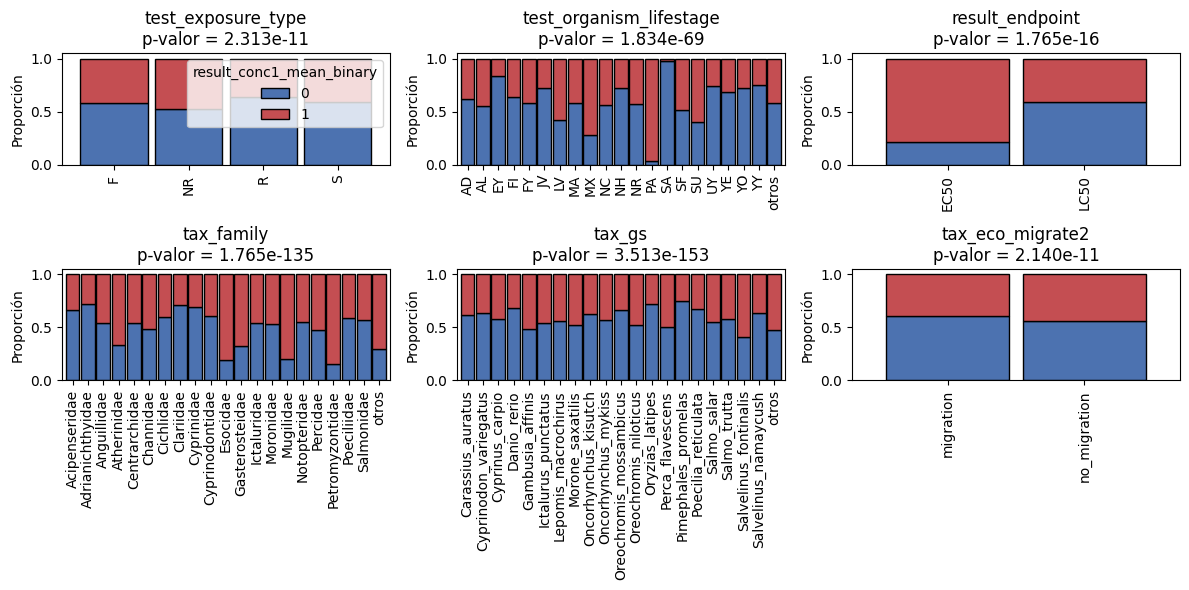

,Variable,p_valor
0,tax_gs,3.512564e-153
1,tax_family,1.764993e-135
2,test_organism_lifestage,1.833949e-69
3,result_endpoint,1.765422e-16
4,tax_eco_migrate2,2.140495e-11
5,test_exposure_type,2.313329e-11


In [57]:
resultados_cat = eda.plot_cat_grouped(
    df=df_modelo,
    variables=vars_cat_analizar,
    target="result_conc1_mean_binary",
    n_cols=3,
    figsize_per_plot=(4, 3),
    max_categories=20  
)
display(resultados_cat)

#### Selección final de variables categóricas para modelado

Tras analizar cada variable categórica frente al target `result_conc1_mean_binary` mediante test chi-cuadrado, visualizaciones proporcionales y distribución univariante, se aplicaron los siguientes criterios de selección:

- **Significancia estadística** (`p < 0.05`)
- **Discriminación visual clara entre clases**
- **Cardinalidad razonable o agrupada**
- **No redundancia con otras variables**

#### Variables seleccionadas para el modelo

| Variable                 | Seleccionada | Justificación                                                                 |
|--------------------------|--------------|-------------------------------------------------------------------------------|
| `test_exposure_type`     | Sí        | Informativa, altamente significativa y con pocas categorías                  |
| `test_organism_lifestage`| Sí        | Significativa; se considerará simplificación si hay ruido                    |
| `result_endpoint`        | Sí        | Binaria, discriminativa y clara                                              |
| `tax_family`             | Sí        | Resume bien la taxonomía con cardinalidad manejable                          |
| `tax_eco_migrate2`       | Sí        | Binaria, con asociación clara con el target                                  |
| `tax_gs`                 | **No**        | Alta cardinalidad, redundante con `tax_family`, riesgo de sobreajuste       |


# Guardado final de features
[Indice](#indice)

In [58]:
# 1. Features preseleccionadas (predictivas)
features_preseleccionadas = [
    # Descriptores moleculares y embeddings
    "chem_mordred_Zagreb1",
    "chem_mordred_TSRW10",
    "chem_mordred_ATSC0d",
    "chem_mordred_TMWC10",
    "chem_mordred_mZagreb2",
    "chem_mordred_ATS3Z",        
    "chem_mordred_Xpc-6dv",
    "chem_mordred_Xpc-5dv",
    "chem_mordred_Xpc-6d",
    "chem_mordred_Sm",
    "chem_mordred_SRW02",
    "chem_mordred_SRW04",
    "chem_mordred_SRW06",
    "chem_mordred_MWC07",
    "chem_mordred_MWC08",
    "chem_mordred_MWC09",
    "chem_mordred_MWC10",
    "chem_mordred_ATS0m",
    "chem_mordred_GGI2",
    "chem_mordred_MPC8",        
    "chem_mol2vec057",

    # Variables categóricas relevantes
    "test_exposure_type",
    "test_organism_lifestage",
    "result_endpoint",
    "tax_family",
    "tax_eco_migrate2"
]


# 2. Features contextuales (no predictivas directas, pero útiles)
features_contextuales = [
    "media_ph_mean", "media_temperature_mean",      # condiciones ambientales
    "tax_lh_licm", "tax_lh_amd",                     # taxonómicas/filogenéticas
    "tax_lh_lpcm", "tax_lh_ri#/d"                    # taxonómicas/filogenéticas
]

# 3. Crear DataFrame con etiquetas
df_features_finales = pd.DataFrame({
    "Variable": features_preseleccionadas + features_contextuales,
    "Tipo": ["predictiva"] * len(features_preseleccionadas) + ["contextual"] * len(features_contextuales)
})

# 4. Mostrar resumen
print(f"Total de variables: {len(df_features_finales)}")
display(df_features_finales)

# 5. Guardar CSV limpio 
df_features_finales.to_csv("../../data/processed/features_seleccionadas.csv", index=False)


Total de variables: 32


,Variable,Tipo
0,chem_mordred_Zagreb1,predictiva
1,chem_mordred_TSRW10,predictiva
2,chem_mordred_ATSC0d,predictiva
3,chem_mordred_TMWC10,predictiva
4,chem_mordred_mZagreb2,predictiva
5,chem_mordred_ATS3Z,predictiva
6,chem_mordred_Xpc-6dv,predictiva
7,chem_mordred_Xpc-5dv,predictiva
8,chem_mordred_Xpc-6d,predictiva
9,chem_mordred_Sm,predictiva


## Definición: 

### Variables predictivas

| Variable                      | Tipo       | Categoría   | Definición ecotoxicológica relevante                                                                 |
|------------------------------|------------|-------------|-------------------------------------------------------------------------------------------------------|
| chem_mordred_*               | Predictiva | Numérica    | Descriptores moleculares calculados automáticamente (Mordred); codifican estructura y propiedades fisicoquímicas de la molécula. Pueden incluir conectividad, masa, electronegatividad, etc. |
| chem_mol2vec057              | Predictiva | Numérica    | Vector embedding generado por Mol2vec; representa la estructura química como vector en espacio latente, útil para capturar patrones moleculares complejos. |
| test_exposure_type           | Predictiva | Categórica  | Tipo de exposición aplicada en el experimento (estática, flujo continuo, renovación, etc.); influye en la biodisponibilidad del tóxico. |
| test_organism_lifestage      | Predictiva | Categórica  | Etapa del ciclo de vida del organismo durante el test (larva, juvenil, adulto); la sensibilidad a tóxicos varía según el desarrollo. |
| result_endpoint              | Predictiva | Categórica  | Tipo de medida toxicológica empleada (e.g., EC50, LC50); define el tipo de efecto agudo medido: mortalidad o inhibición. |
| tax_family                   | Predictiva | Categórica  | Familia taxonómica del organismo usado en el test; refleja similitudes evolutivas y fisiológicas que afectan su sensibilidad. |
| tax_eco_migrate2             | Predictiva | Categórica  | Comportamiento migratorio del organismo (migratorio vs. sedentario); puede afectar su exposición ambiental real a tóxicos. |

### Variables contextuales

| Variable                      | Tipo        | Categoría   | Definición ecotoxicológica relevante                                                                  |
|------------------------------|-------------|-------------|--------------------------------------------------------------------------------------------------------|
| media_ph_mean                | Contextual  | Numérica    | Valor medio del pH durante el experimento; el pH puede alterar la toxicidad efectiva de muchas sustancias químicas. |
| media_temperature_mean       | Contextual  | Numérica    | Temperatura media del agua; influye en la toxicocinética y toxicodinámica de las sustancias en los peces. |
| tax_lh_licm                  | Contextual  | Numérica    | Descriptor del historial de vida relacionado con longevidad, tamaño corporal, maduración (Life History Traits). |
| tax_lh_amd                   | Contextual  | Numérica    | Edad media a la madurez del organismo; afecta su resiliencia poblacional y sensibilidad ecotoxicológica. |
| tax_lh_lpcm                  | Contextual  | Numérica    | Longitud promedio corporal máxima del organismo; puede relacionarse con su capacidad de acumulación de tóxicos. |
| tax_lh_ri#/d                 | Contextual  | Numérica    | Ritmo reproductivo estimado (número de individuos por día); refleja la velocidad de renovación poblacional. |
